# Regression Tree Analysis - Ames Housing Dataset

This notebook demonstrates:
- Using the from-scratch RegressionTree implementation from `src/regression_tree.py`
- Comprehensive hyperparameter analysis
- **Cost-Complexity Pruning (CCP)** - Post-pruning technique
- Model comparison with sklearn
- Cross-validation evaluation

## Pipeline Design
```
Dataset → Preprocessing → Train/Test Split → 
    → Regression Tree Training (with/without CCP)
    → Hyperparameter Tuning
    → Cross-Validation
    → Model Comparison
    → Visualization
```


## 1. Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from pathlib import Path
import sys
import time
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path to import our RegressionTree
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Import our from-scratch implementation (with reload to pick up changes)
import importlib
import regression_tree
importlib.reload(regression_tree)
from regression_tree import RegressionTree, OptimizedRegressionTree, print_tree

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✓ Imports successful!")
print(f"RegressionTree module imported from: {Path.cwd().parent / 'src' / 'regression_tree.py'}")


✓ Imports successful!
RegressionTree module imported from: /Users/julianhardt/Library/Mobile Documents/com~apple~CloudDocs/Datascience/5.Semester/Machine Learning/excercise_2/ml-exercise2/ml_implementation/src/regression_tree.py


## 2. Data Loading


In [2]:
# Configuration
DATA_DIR = Path.cwd().parent / 'data' / 'processed'
RESULTS_DIR = Path.cwd().parent / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

# ============================================================
# DATASET: Ames Housing
# ============================================================
X = np.load(DATA_DIR / 'ames_X.npy')
y = np.load(DATA_DIR / 'ames_y.npy')
feature_names_file = DATA_DIR / 'ames_feature_names.npy'
TARGET_NAME = "SalePrice"

# Load feature names
if feature_names_file.exists():
    feature_names = list(np.load(feature_names_file, allow_pickle=True))
else:
    feature_names = [f'X{i}' for i in range(X.shape[1])]

print(f"\n{'='*60}")
print(f"DATASET: AMES HOUSING")
print(f"{'='*60}")
print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}")
print(f"Target: {TARGET_NAME}")
print(f"Features: {feature_names[:5]}..." if len(feature_names) > 5 else f"Features: {feature_names}")


DATASET: AMES HOUSING
Samples: 1460, Features: 243
Target: SalePrice
Features: [np.str_('MSSubClass'), np.str_('LotFrontage'), np.str_('LotArea'), np.str_('OverallQual'), np.str_('OverallCond')]...


In [3]:
# Train/Test Split
# For large datasets like Airbnb, use a smaller subset for faster training
# while still demonstrating CCP effectively

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 1168, Test size: 292


## 3. Basic Model Training & Evaluation


In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test, name="Model"):
    """Evaluate a model and print metrics."""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"\n{name}")
    print("-" * 40)
    print(f"Train MSE: {train_mse:,.2f}")
    print(f"Train R²:  {train_r2:.4f}")
    print(f"Test MSE:  {test_mse:,.2f}")
    print(f"Test R²:   {test_r2:.4f}")
    print(f"Test MAE:  {test_mae:,.2f}")
    
    return {
        'model': name,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae
    }


In [5]:
# Train unpruned tree (default hyperparameters)
print("Training Unpruned Tree...")
start = time.time()
our_tree = OptimizedRegressionTree(max_depth=12, min_samples_leaf=1, min_samples_split=2)
our_tree.fit(X_train, y_train)
our_time = time.time() - start
print(f"Training time: {our_time:.2f}s")

results = []
results.append(evaluate_model(our_tree, X_train, X_test, y_train, y_test, "Unpruned Tree"))
results[-1]['n_leaves'] = our_tree.get_n_leaves()
results[-1]['depth'] = our_tree.get_depth()


Training Unpruned Tree...
Training time: 2.47s

Unpruned Tree
----------------------------------------
Train MSE: 43,534,699.22
Train R²:  0.9932
Test MSE:  1,503,005,198.21
Test R²:   0.7531
Test MAE:  26,237.66


In [6]:
# sklearn DecisionTree (comparison)
print("Training sklearn DecisionTreeRegressor...")
start = time.time()
sklearn_tree = DecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
sklearn_tree.fit(X_train, y_train)
sklearn_time = time.time() - start
print(f"Training time: {sklearn_time:.2f}s")

results.append(evaluate_model(sklearn_tree, X_train, X_test, y_train, y_test, "sklearn DecisionTree"))
results[-1]['n_leaves'] = sklearn_tree.get_n_leaves()
results[-1]['depth'] = sklearn_tree.get_depth()


Training sklearn DecisionTreeRegressor...
Training time: 0.01s

sklearn DecisionTree
----------------------------------------
Train MSE: 159,547,075.91
Train R²:  0.9749
Test MSE:  1,619,138,078.31
Test R²:   0.7341
Test MAE:  26,081.78


In [7]:
# Linear Regression (baseline)
print("Training Linear Regression (baseline)...")
lr = LinearRegression()
lr.fit(X_train, y_train)
results.append(evaluate_model(lr, X_train, X_test, y_train, y_test, "Linear Regression"))


Training Linear Regression (baseline)...

Linear Regression
----------------------------------------
Train MSE: 458,799,825.30
Train R²:  0.9279
Test MSE:  1,441,902,390.44
Test R²:   0.7632
Test MAE:  20,968.28


## 4. Cost-Complexity Pruning (CCP) Analysis

### What is Cost-Complexity Pruning?

Cost-Complexity Pruning (CCP) is a **post-pruning** technique that:

1. **Builds a full tree first** (maximum depth)
2. **Then prunes it back** by replacing subtrees with single leaves
3. **Uses parameter α (alpha)** to control the trade-off between complexity and accuracy

### The Formula

For each internal node, we calculate the **effective alpha**:

$$\alpha_{eff} = \frac{R(t) - R(T_t)}{|T_t| - 1}$$

Where:
- $R(t)$ = Impurity (MSE × n_samples) if this node were a leaf
- $R(T_t)$ = Total impurity of subtree rooted at $t$
- $|T_t|$ = Number of leaves in the subtree

**Interpretation:**
- Low α: Complex tree remains (less pruning)
- High α: Simpler tree (more pruning)


In [8]:
# Compute the Cost-Complexity Pruning path
print("Computing Cost-Complexity Pruning Path...")

# Use deeper tree to create more overfitting (which CCP can then prune)
tree_for_path = OptimizedRegressionTree(max_depth=25)
path = tree_for_path.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path['ccp_alphas']
impurities = path['impurities']

print(f"\nNumber of alpha values in path: {len(ccp_alphas)}")
print(f"Alpha range: [{ccp_alphas.min():.2e}, {ccp_alphas.max():.2e}]")
print(f"\nFirst 10 alphas: {ccp_alphas[:10]}")
print(f"Last 5 alphas: {ccp_alphas[-5:]}")

Computing Cost-Complexity Pruning Path...

Number of alpha values in path: 470
Alpha range: [0.00e+00, 3.37e+12]

First 10 alphas: [      0.            6666.66666667    6666.66666667   42504.16666667
  520083.33333333  666666.66666667  716912.66666667 1500000.
 1562500.         1613333.33333333]
Last 5 alphas: [2.95089948e+11 3.11645732e+11 5.45029563e+11 8.08353470e+11
 3.36668364e+12]


In [9]:
# Evaluate performance for different alpha values from the pruning path
print("Evaluating performance across alpha values from pruning path...")

# Sample alphas from the full range to see the effect
if len(ccp_alphas) > 25:
    indices = np.linspace(0, len(ccp_alphas)-1, 25, dtype=int)
    alpha_values = ccp_alphas[indices]
else:
    alpha_values = ccp_alphas

print(f"Testing {len(alpha_values)} alpha values...")

ccp_results = []
start_ccp = time.time()
for i, alpha in enumerate(alpha_values):
    # Use same max_depth as path computation
    tree = OptimizedRegressionTree(max_depth=15, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    
    train_r2 = tree.score(X_train, y_train)
    test_r2 = tree.score(X_test, y_test)
    n_leaves = tree.get_n_leaves()
    depth = tree.get_depth()
    
    ccp_results.append({
        'alpha': alpha,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_leaves': n_leaves,
        'depth': depth
    })
    
    if (i+1) % 5 == 0:
        print(f"  [{i+1}/{len(alpha_values)}] α={alpha:.2e}, leaves={n_leaves}, test R²={test_r2:.4f}")

ccp_df = pd.DataFrame(ccp_results)
print(f"\nDone! Evaluated {len(alpha_values)} alpha values in {time.time() - start_ccp:.1f}s")

Evaluating performance across alpha values from pruning path...
Testing 25 alpha values...
  [5/25] α=4.54e+07, leaves=497, test R²=0.7549
  [10/25] α=2.46e+08, leaves=330, test R²=0.7616
  [15/25] α=8.78e+08, leaves=208, test R²=0.7652
  [20/25] α=3.05e+09, leaves=101, test R²=0.7595
  [25/25] α=3.37e+12, leaves=2, test R²=0.4579

Done! Evaluated 25 alpha values in 77.6s


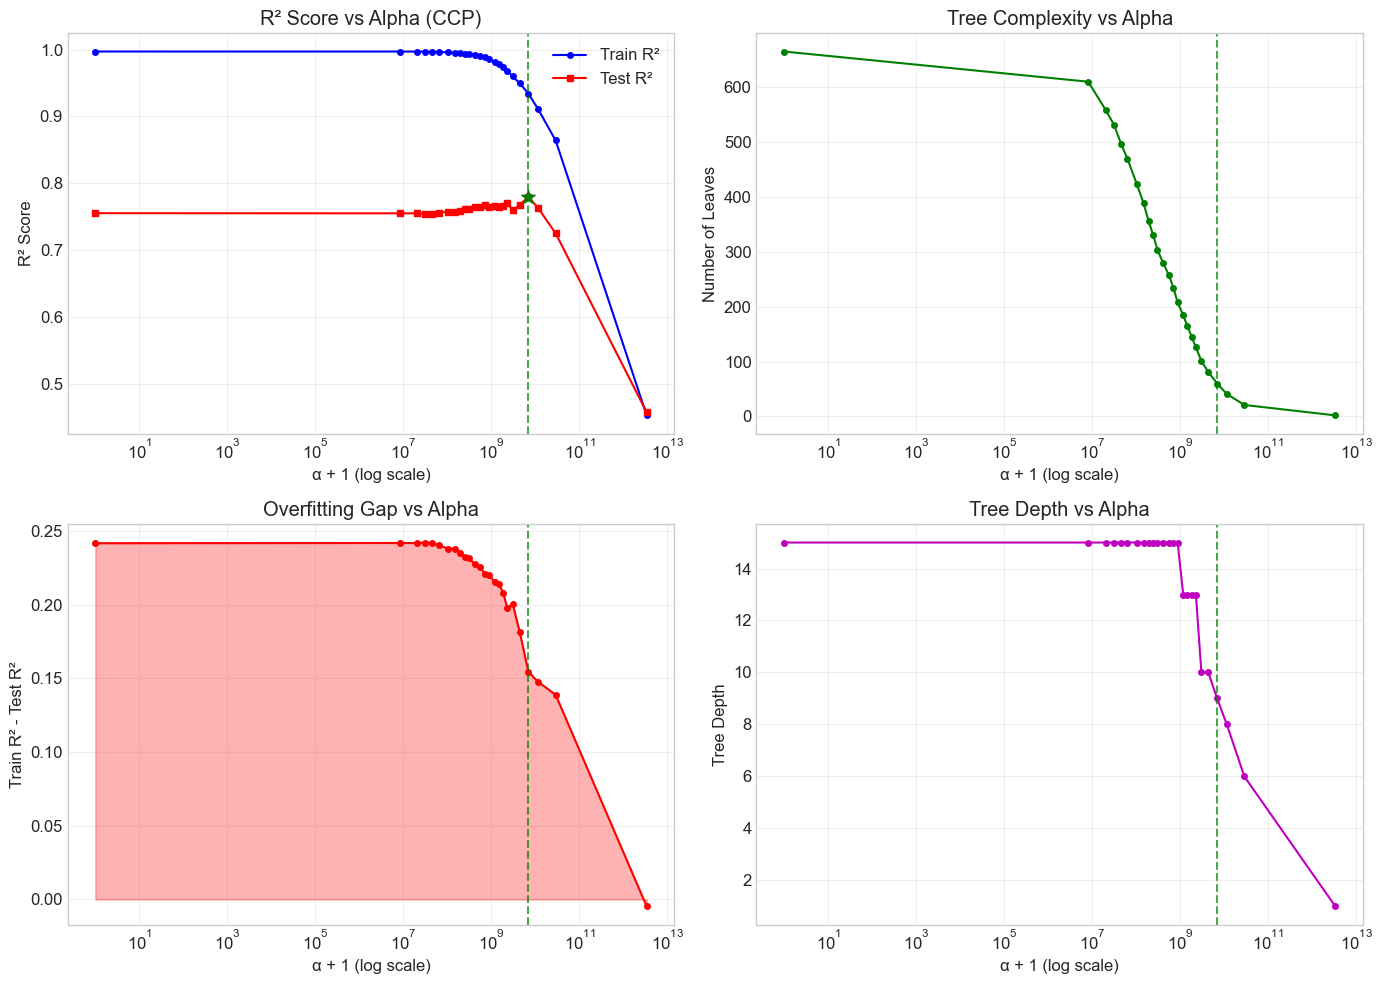


BEST ALPHA (max Test R²): 6.94e+09
Best Test R²: 0.7798
Train R² at best: 0.9341
Leaves at best: 60
Depth at best: 9


In [10]:
# Plot CCP analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: R² vs alpha (log scale)
ax1 = axes[0, 0]
ax1.semilogx(ccp_df['alpha'] + 1, ccp_df['train_r2'], 'b-o', label='Train R²', markersize=4)
ax1.semilogx(ccp_df['alpha'] + 1, ccp_df['test_r2'], 'r-s', label='Test R²', markersize=4)
ax1.set_xlabel('α + 1 (log scale)')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score vs Alpha (CCP)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Find optimal alpha (best test R²)
best_idx = ccp_df['test_r2'].idxmax()
best_alpha = ccp_df.loc[best_idx, 'alpha']
best_test_r2 = ccp_df.loc[best_idx, 'test_r2']
ax1.axvline(best_alpha + 1, color='green', linestyle='--', alpha=0.7)
ax1.scatter([best_alpha + 1], [best_test_r2], color='green', s=100, zorder=5, marker='*')

# Plot 2: Number of leaves vs alpha
ax2 = axes[0, 1]
ax2.semilogx(ccp_df['alpha'] + 1, ccp_df['n_leaves'], 'g-o', markersize=4)
ax2.set_xlabel('α + 1 (log scale)')
ax2.set_ylabel('Number of Leaves')
ax2.set_title('Tree Complexity vs Alpha')
ax2.axvline(best_alpha + 1, color='green', linestyle='--', alpha=0.7)
ax2.grid(True, alpha=0.3)

# Plot 3: Overfitting gap
ax3 = axes[1, 0]
gap = ccp_df['train_r2'] - ccp_df['test_r2']
ax3.semilogx(ccp_df['alpha'] + 1, gap, 'r-o', markersize=4)
ax3.fill_between(ccp_df['alpha'] + 1, 0, gap, alpha=0.3, color='red')
ax3.set_xlabel('α + 1 (log scale)')
ax3.set_ylabel('Train R² - Test R²')
ax3.set_title('Overfitting Gap vs Alpha')
ax3.axvline(best_alpha + 1, color='green', linestyle='--', alpha=0.7)
ax3.grid(True, alpha=0.3)

# Plot 4: Tree depth vs alpha
ax4 = axes[1, 1]
ax4.semilogx(ccp_df['alpha'] + 1, ccp_df['depth'], 'm-o', markersize=4)
ax4.set_xlabel('α + 1 (log scale)')
ax4.set_ylabel('Tree Depth')
ax4.set_title('Tree Depth vs Alpha')
ax4.axvline(best_alpha + 1, color='green', linestyle='--', alpha=0.7)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ccp_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print(f"BEST ALPHA (max Test R²): {best_alpha:.2e}")
print(f"Best Test R²: {best_test_r2:.4f}")
print(f"Train R² at best: {ccp_df.loc[best_idx, 'train_r2']:.4f}")
print(f"Leaves at best: {ccp_df.loc[best_idx, 'n_leaves']}")
print(f"Depth at best: {ccp_df.loc[best_idx, 'depth']}")
print(f"{'='*60}")

In [11]:
# Train optimal pruned tree with best_alpha
print(f"Training Pruned Tree with best alpha={best_alpha:.2e}...")
pruned_tree = OptimizedRegressionTree(max_depth=15, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

results.append(evaluate_model(pruned_tree, X_train, X_test, y_train, y_test, "RegressionTree + CCP"))
results[-1]['n_leaves'] = pruned_tree.get_n_leaves()
results[-1]['depth'] = pruned_tree.get_depth()
results[-1]['ccp_alpha'] = best_alpha

Training Pruned Tree with best alpha=6.94e+09...

RegressionTree + CCP
----------------------------------------
Train MSE: 418,878,771.63
Train R²:  0.9341
Test MSE:  1,340,374,379.69
Test R²:   0.7798
Test MAE:  24,680.68


In [12]:
# Compare unpruned (full) vs pruned tree - FRESH TRAINING
print("\n" + "="*70)
print("COMPARISON: Full Tree vs Pruned Tree")
print("="*70)

# IMPORTANT: Train FRESH trees to avoid any cached state issues
print("\nTraining fresh trees for comparison...")

# Full tree (alpha=0, no pruning)
full_tree_compare = OptimizedRegressionTree(max_depth=20, ccp_alpha=0)
full_tree_compare.fit(X_train, y_train)

# Pruned tree with best_alpha
pruned_tree_compare = OptimizedRegressionTree(max_depth=20, ccp_alpha=best_alpha)
pruned_tree_compare.fit(X_train, y_train)

print(f"Full tree: {full_tree_compare.get_n_leaves()} leaves, depth {full_tree_compare.get_depth()}")
print(f"Pruned tree (α={best_alpha:.2e}): {pruned_tree_compare.get_n_leaves()} leaves, depth {pruned_tree_compare.get_depth()}")

# Get FRESH predictions
pred_full = full_tree_compare.predict(X_test)
pred_pruned = pruned_tree_compare.predict(X_test)

# Calculate metrics from predictions
full_train_r2 = r2_score(y_train, full_tree_compare.predict(X_train))
full_test_r2 = r2_score(y_test, pred_full)
pruned_train_r2 = r2_score(y_train, pruned_tree_compare.predict(X_train))
pruned_test_r2 = r2_score(y_test, pred_pruned)

# Verify predictions are different
print(f"\nPrediction check:")
print(f"  Max difference in predictions: {np.max(np.abs(pred_full - pred_pruned)):.2f}")
print(f"  Predictions identical? {np.allclose(pred_full, pred_pruned)}")

print(f"\n{'Metric':<20} | {'Full Tree (α=0)':<20} | {'Pruned (α={:.2e})':<20}".format(best_alpha))
print("-" * 65)
print(f"{'Leaves':<20} | {full_tree_compare.get_n_leaves():<20} | {pruned_tree_compare.get_n_leaves():<20}")
print(f"{'Depth':<20} | {full_tree_compare.get_depth():<20} | {pruned_tree_compare.get_depth():<20}")
print(f"{'Train R²':<20} | {full_train_r2:<20.4f} | {pruned_train_r2:<20.4f}")
print(f"{'Test R²':<20} | {full_test_r2:<20.4f} | {pruned_test_r2:<20.4f}")
print(f"{'Overfitting Gap':<20} | {full_train_r2-full_test_r2:<20.4f} | {pruned_train_r2-pruned_test_r2:<20.4f}")

# Summary
print(f"\n{'='*65}")
test_change = pruned_test_r2 - full_test_r2
gap_change = (full_train_r2-full_test_r2) - (pruned_train_r2-pruned_test_r2)
leaf_reduction = 100 * (1 - pruned_tree_compare.get_n_leaves() / full_tree_compare.get_n_leaves())
print(f"Test R² change: {test_change:+.4f}")
print(f"Overfitting gap reduction: {gap_change:+.4f}")
print(f"Complexity reduction: {full_tree_compare.get_n_leaves()} → {pruned_tree_compare.get_n_leaves()} ({leaf_reduction:.1f}% fewer leaves)")


COMPARISON: Full Tree vs Pruned Tree

Training fresh trees for comparison...
Full tree: 760 leaves, depth 20
Pruned tree (α=6.94e+09): 60 leaves, depth 9

Prediction check:
  Max difference in predictions: 67866.67
  Predictions identical? False

Metric               | Full Tree (α=0)      | Pruned (α=6.94e+09)   
-----------------------------------------------------------------
Leaves               | 760                  | 60                  
Depth                | 20                   | 9                   
Train R²             | 0.9977               | 0.9341              
Test R²              | 0.7555               | 0.7798              
Overfitting Gap      | 0.2421               | 0.1543              

Test R² change: +0.0243
Overfitting gap reduction: +0.0878
Complexity reduction: 760 → 60 (92.1% fewer leaves)


## 5. Cross-Validation for Optimal Alpha


In [13]:
# Cross-validation to find optimal alpha
print("Cross-Validation for Optimal CCP Alpha...")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Use alphas from the pruning path for CV (sample a reasonable range)
# Focus on the middle range where pruning has meaningful effect
mid_alphas = ccp_alphas[len(ccp_alphas)//4 : 3*len(ccp_alphas)//4]
if len(mid_alphas) > 8:
    cv_indices = np.linspace(0, len(mid_alphas)-1, 8, dtype=int)
    alpha_values_cv = mid_alphas[cv_indices]
else:
    alpha_values_cv = mid_alphas
alpha_values_cv = np.insert(alpha_values_cv, 0, 0)  # Include no-pruning baseline

cv_results = []
start_cv = time.time()
for i, alpha in enumerate(alpha_values_cv):
    fold_scores = []
    for train_idx, val_idx in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        tree = OptimizedRegressionTree(max_depth=15, ccp_alpha=alpha)
        tree.fit(X_fold_train, y_fold_train)
        score = r2_score(y_fold_val, tree.predict(X_fold_val))
        fold_scores.append(score)

    cv_results.append({
        'alpha': alpha,
        'cv_mean': np.mean(fold_scores),
        'cv_std': np.std(fold_scores)
    })
    print(f"  [{i+1}/{len(alpha_values_cv)}] α={alpha:.2e}, CV R²={np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

cv_df = pd.DataFrame(cv_results)
print(f"\nCV completed in {time.time() - start_cv:.1f}s")

# Find best
best_cv_idx = cv_df['cv_mean'].idxmax()
best_cv_alpha = cv_df.loc[best_cv_idx, 'alpha']
best_cv_score = cv_df.loc[best_cv_idx, 'cv_mean']

print(f"\nOptimal Alpha (CV): {best_cv_alpha:.4e}")
print(f"Best CV R²: {best_cv_score:.4f} ± {cv_df.loc[best_cv_idx, 'cv_std']:.4f}")

Cross-Validation for Optimal CCP Alpha...
  [1/9] α=0.00e+00, CV R²=0.7248 ± 0.0474
  [2/9] α=1.04e+08, CV R²=0.7250 ± 0.0489
  [3/9] α=1.78e+08, CV R²=0.7252 ± 0.0490
  [4/9] α=2.75e+08, CV R²=0.7268 ± 0.0479
  [5/9] α=4.53e+08, CV R²=0.7289 ± 0.0470
  [6/9] α=6.59e+08, CV R²=0.7314 ± 0.0459
  [7/9] α=1.04e+09, CV R²=0.7313 ± 0.0415
  [8/9] α=1.55e+09, CV R²=0.7336 ± 0.0411
  [9/9] α=2.28e+09, CV R²=0.7426 ± 0.0364

CV completed in 112.0s

Optimal Alpha (CV): 2.2808e+09
Best CV R²: 0.7426 ± 0.0364


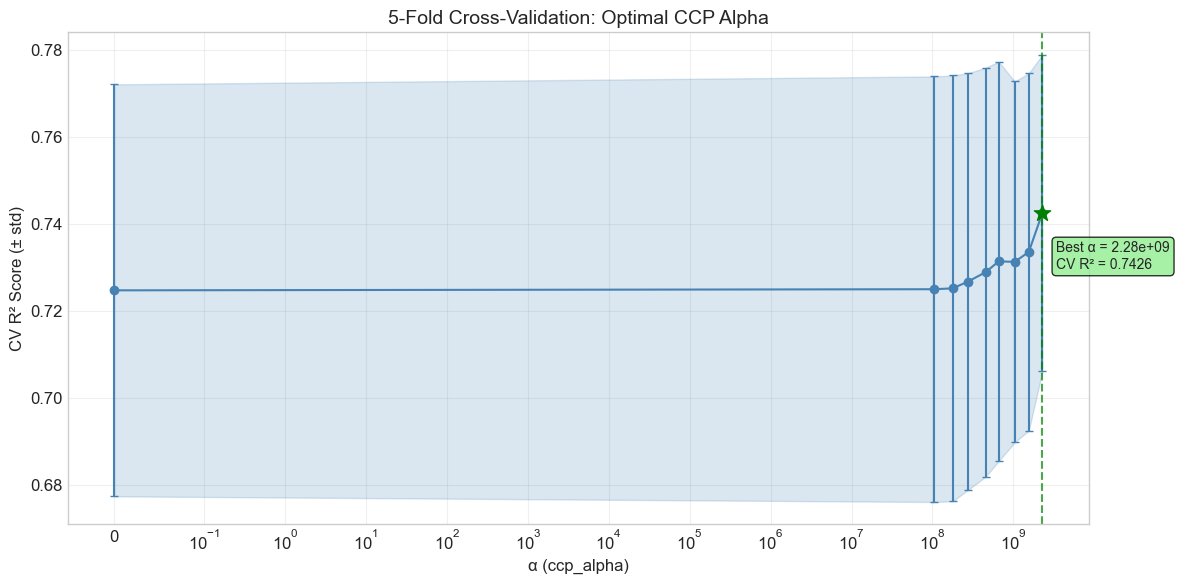

In [14]:
# Plot CV results
fig, ax = plt.subplots(figsize=(12, 6))

ax.errorbar(cv_df['alpha'], cv_df['cv_mean'], yerr=cv_df['cv_std'],
            fmt='-o', capsize=3, markersize=6, color='steelblue')
ax.fill_between(cv_df['alpha'], 
                cv_df['cv_mean'] - cv_df['cv_std'],
                cv_df['cv_mean'] + cv_df['cv_std'],
                alpha=0.2, color='steelblue')

# Mark best alpha
ax.axvline(best_cv_alpha, color='green', linestyle='--', alpha=0.7)
ax.scatter([best_cv_alpha], [best_cv_score], color='green', s=150, marker='*', zorder=5)
ax.annotate(f'Best α = {best_cv_alpha:.2e}\nCV R² = {best_cv_score:.4f}',
            xy=(best_cv_alpha, best_cv_score), xytext=(10, -40),
            textcoords='offset points', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))

ax.set_xlabel('α (ccp_alpha)', fontsize=12)
ax.set_ylabel('CV R² Score (± std)', fontsize=12)
ax.set_title('5-Fold Cross-Validation: Optimal CCP Alpha', fontsize=14)
ax.set_xscale('symlog', linthresh=1e-1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ccp_cross_validation.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Other Hyperparameter Analysis


In [15]:
# Effect of max_depth
print("Analyzing effect of max_depth...")
depths = range(1, 21)
depth_results = []

for d in depths:
    tree = OptimizedRegressionTree(max_depth=d, min_samples_split=5)
    tree.fit(X_train, y_train)
    
    train_r2 = r2_score(y_train, tree.predict(X_train))
    test_r2 = r2_score(y_test, tree.predict(X_test))
    
    depth_results.append({
        'max_depth': d,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_leaves': tree.get_n_leaves()
    })

depth_df = pd.DataFrame(depth_results)

# Effect of min_samples_split
print("Analyzing effect of min_samples_split...")
splits = [2, 5, 10, 20, 50, 100, 200]
split_results = []

for s in splits:
    tree = OptimizedRegressionTree(max_depth=10, min_samples_split=s)
    tree.fit(X_train, y_train)
    
    train_r2 = r2_score(y_train, tree.predict(X_train))
    test_r2 = r2_score(y_test, tree.predict(X_test))
    
    split_results.append({
        'min_samples_split': s,
        'train_r2': train_r2,
        'test_r2': test_r2
    })

split_df = pd.DataFrame(split_results)

# Effect of min_samples_leaf
print("Analyzing effect of min_samples_leaf...")
leaves = [1, 2, 5, 10, 20, 50, 100]
leaf_results = []

for l in leaves:
    tree = OptimizedRegressionTree(max_depth=10, min_samples_leaf=l)
    tree.fit(X_train, y_train)
    
    train_r2 = r2_score(y_train, tree.predict(X_train))
    test_r2 = r2_score(y_test, tree.predict(X_test))
    
    leaf_results.append({
        'min_samples_leaf': l,
        'train_r2': train_r2,
        'test_r2': test_r2
    })

leaf_df = pd.DataFrame(leaf_results)
print("Done!")


Analyzing effect of max_depth...
Analyzing effect of min_samples_split...
Analyzing effect of min_samples_leaf...
Done!


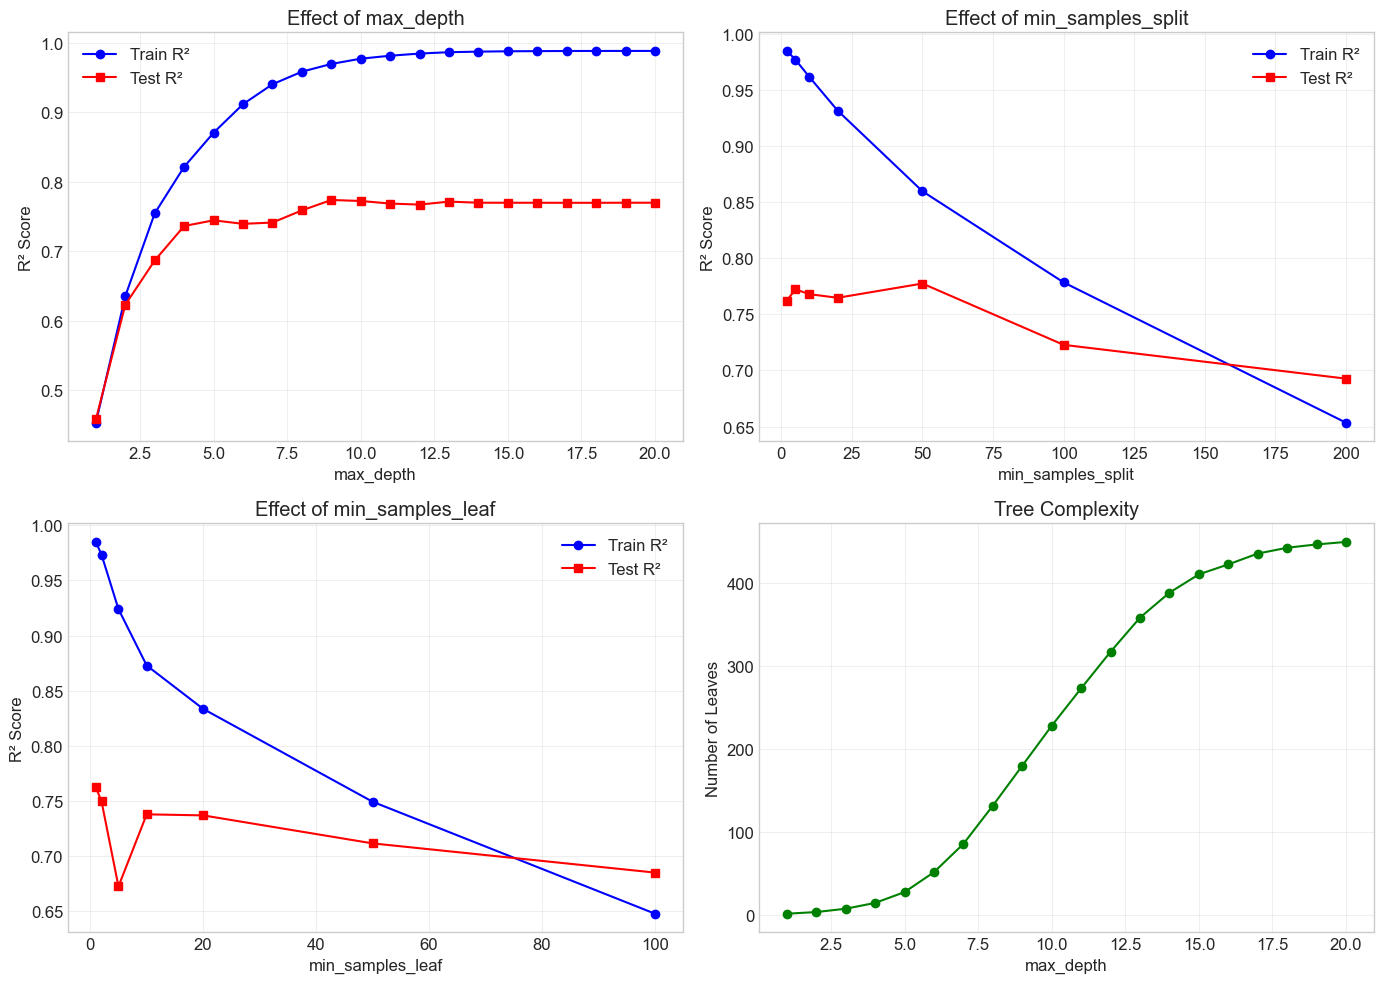

In [16]:
# Combined visualization of hyperparameters
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# max_depth
ax1 = axes[0, 0]
ax1.plot(depth_df['max_depth'], depth_df['train_r2'], 'b-o', label='Train R²')
ax1.plot(depth_df['max_depth'], depth_df['test_r2'], 'r-s', label='Test R²')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('R² Score')
ax1.set_title('Effect of max_depth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# min_samples_split
ax2 = axes[0, 1]
ax2.plot(split_df['min_samples_split'], split_df['train_r2'], 'b-o', label='Train R²')
ax2.plot(split_df['min_samples_split'], split_df['test_r2'], 'r-s', label='Test R²')
ax2.set_xlabel('min_samples_split')
ax2.set_ylabel('R² Score')
ax2.set_title('Effect of min_samples_split')
ax2.legend()
ax2.grid(True, alpha=0.3)

# min_samples_leaf
ax3 = axes[1, 0]
ax3.plot(leaf_df['min_samples_leaf'], leaf_df['train_r2'], 'b-o', label='Train R²')
ax3.plot(leaf_df['min_samples_leaf'], leaf_df['test_r2'], 'r-s', label='Test R²')
ax3.set_xlabel('min_samples_leaf')
ax3.set_ylabel('R² Score')
ax3.set_title('Effect of min_samples_leaf')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Number of leaves vs depth
ax4 = axes[1, 1]
ax4.plot(depth_df['max_depth'], depth_df['n_leaves'], 'g-o')
ax4.set_xlabel('max_depth')
ax4.set_ylabel('Number of Leaves')
ax4.set_title('Tree Complexity')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'hyperparameter_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Final Model Comparison



FINAL MODEL COMPARISON
               model    train_mse     test_mse  train_r2  test_r2     test_mae  n_leaves  depth    ccp_alpha
       Unpruned Tree 4.353470e+07 1.503005e+09  0.993155 0.753133 26237.661507     479.0   12.0          NaN
sklearn DecisionTree 1.595471e+08 1.619138e+09  0.974914 0.734059 26081.776539     224.0   10.0          NaN
   Linear Regression 4.587998e+08 1.441902e+09  0.927860 0.763169 20968.281927       NaN    NaN          NaN
RegressionTree + CCP 4.188788e+08 1.340374e+09  0.934137 0.779845 24680.677220      60.0    9.0 6.940086e+09


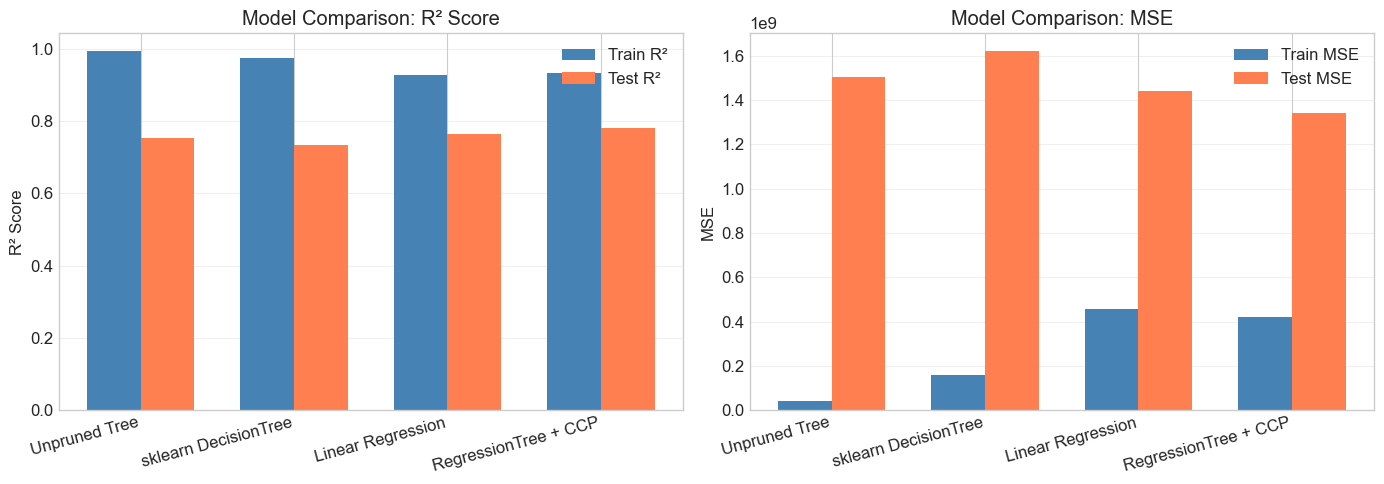

In [17]:
# Summary table
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

# Model comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
ax1 = axes[0]
x = range(len(results_df))
width = 0.35
ax1.bar([i - width/2 for i in x], results_df['train_r2'], width, label='Train R²', color='steelblue')
ax1.bar([i + width/2 for i in x], results_df['test_r2'], width, label='Test R²', color='coral')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['model'], rotation=15, ha='right')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Comparison: R² Score')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# MSE comparison
ax2 = axes[1]
ax2.bar([i - width/2 for i in x], results_df['train_mse'], width, label='Train MSE', color='steelblue')
ax2.bar([i + width/2 for i in x], results_df['test_mse'], width, label='Test MSE', color='coral')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['model'], rotation=15, ha='right')
ax2.set_ylabel('MSE')
ax2.set_title('Model Comparison: MSE')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [18]:
# Save results
results_df.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)
ccp_df.to_csv(RESULTS_DIR / 'ccp_analysis.csv', index=False)
cv_df.to_csv(RESULTS_DIR / 'ccp_cross_validation.csv', index=False)

print("\nResults saved to:")
print(f"  - {RESULTS_DIR / 'model_comparison.csv'}")
print(f"  - {RESULTS_DIR / 'ccp_analysis.csv'}")
print(f"  - {RESULTS_DIR / 'ccp_cross_validation.csv'}")
print(f"  - Visualizations: {RESULTS_DIR}/*.png")



Results saved to:
  - /Users/julianhardt/Library/Mobile Documents/com~apple~CloudDocs/Datascience/5.Semester/Machine Learning/excercise_2/ml-exercise2/ml_implementation/results/model_comparison.csv
  - /Users/julianhardt/Library/Mobile Documents/com~apple~CloudDocs/Datascience/5.Semester/Machine Learning/excercise_2/ml-exercise2/ml_implementation/results/ccp_analysis.csv
  - /Users/julianhardt/Library/Mobile Documents/com~apple~CloudDocs/Datascience/5.Semester/Machine Learning/excercise_2/ml-exercise2/ml_implementation/results/ccp_cross_validation.csv
  - Visualizations: /Users/julianhardt/Library/Mobile Documents/com~apple~CloudDocs/Datascience/5.Semester/Machine Learning/excercise_2/ml-exercise2/ml_implementation/results/*.png
